In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

from sklearn.cluster import KMeans 
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AgglomerativeClustering
from pathlib import Path

In [3]:
import sys

sys.path.append('../../../src')



In [4]:
from base_exp_gen import generate_experiment as GEN_EXP
from clustering_algos import agglomerative_clustering, kmeans_clustering,\
box_clustering, adaptive_box2, optimal_clustering
from sklearn.model_selection import train_test_split as datasplit
from sklearn.ensemble import GradientBoostingRegressor as GDBR
from evaluations import computeATT_per_cluster as ATTC, predict_cf, calculate_ite, get_homogeneity, generate_paths

from econml.metalearners import XLearner as XL
from sklearn.ensemble import RandomForestClassifier as RF

/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/statsmodels/compat/pandas.py:49: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


In [5]:
def MAE_pd(group, name1,name2,column_name):
    
    group[column_name] = np.abs(group[name1].values-group[name2].mean())
    return group

In [6]:
np.random.seed(seed = 0)

In [7]:
fonts = {'family': 'cmr10','weight': 'normal',
            'size': 20}    
div = 1

l1 = 22/div
l2 = 20/div
l3 = 13/(div-0.2)

mpl.rcParams['xtick.labelsize'] = l2
mpl.rcParams['ytick.labelsize'] = l2
mpl.rcParams['axes.labelsize'] = l1
mpl.rcParams['font.serif'] = 'Times New Roman'
mpl.rcParams['font.weight'] = 'normal'
mpl.rcParams['font.size'] = 20
mpl.rcParams['legend.fontsize'] = l3

#axes_font = {'labelsize':l1}
#mpl.rc('font', **font)
#xticks = {'labelsize':l2}# 'ytick.labelsize':20}
#yticks = {'labelsize':l2}# 'ytick.labelsize':20}
#legend = {'fontsize':l3}
# tex = {'usetex':True}
#mpl.rc('axes', **axes_font)
#mpl.rc('xtick', **xticks)
#mpl.rc('ytick', **yticks)
#mpl.rc('font', **fonts)
#mpl.rc('legend', **legend)

In [8]:
pd.set_option("display.max_columns", None)


### Generate Experiment

In [9]:
%%time
n = [5*10**4, 2*10**5, 5*10**5, 1*10**6, 2*10**6]
z = [0.2, 0.5, 1,1.1, 1.2, 1.5,1.8, 2,2.2, 2.5,2.7,3, 3.5, 3.8, 4]
#z = [0.2, 0.5, 1, 2.5, 3]

zstr = [str(el*100)+'%' for el in z]
ERRORS = np.zeros([len(n), len(z)])
ERRORS_pd = pd.DataFrame(ERRORS, index = n, columns = zstr)

for i,N in enumerate(n):
    np.random.seed(seed = 0)
    D =  2
    x = int((N)**(1/4))
    kw_generate =  {'N':N, 'D':D,'f_gen_name': 'uniform_gen','low':0, 'high': 1}
    centers = [[0.25,0.25],[0.5,0.5],[0.75,0.75],[0.75,0.25], [0.25,0.75]]
    r_small = [0.122]*5
    r_big = [0.2,0.2,0.2, 0.2,0.2]
    kw_cluster =  {'f_class_name':'circle_class3', 'centers': centers, 'r_small': r_small, 'r_big':r_big}
    kw_treatment = {'f_treat_name' :'uniform_treat','choices':[0,1], 'probabilities':[0.5,0.5]}

    std = 2
    stats = np.array([[1, std], [0, std], [0, std], [0, std],[0, std],
                      [0, std],[1, std],[1, std],[2, std],[3, std],[4, std],[5, std]])
    kw_outcome = {'f_outcome_name': 'outcome1','treatment':'Treatment', 'cls':'C', 'stats':stats}

    data3 = GEN_EXP(kw_generate, kw_cluster, kw_treatment, kw_outcome).dat
    data3 = calculate_ite(data3.copy(), treatment = 'Treatment',
                         counterfactual = 'Ycf', outcome = 'Y', ite_name = 'ITE')

    clusts = [int((y*x)**2) for y in z]
    
    #CALCULATE ITES
    f1_kwargs = {'n_estimators':400, 'max_depth':18}
    f2_kwargs = {'n_estimators':400, 'max_depth':18}

    data3, models = predict_cf(data3.copy(), col_select = ['x0', 'x1'], f1 = GDBR,
                              f2 = GDBR, cf_name = 'Ycf-GDBR', f1_kwargs=f1_kwargs, 
                              f2_kwargs=f2_kwargs, ite_name ='ITE-GDBR')


    for j,clusters in enumerate(clusts):
        print("Number of Clusters:{}, Number of Points:{}".format(clusters, N))

        data = data3.copy()
        #BOX CLUSTERING
        col_select = ['x0', 'x1']
        data,_ = box_clustering(data.copy(), clusters = clusters, col_select = col_select )

        #CALCULATE ATT PER CLUSTER
        ite_name = 'ITE-GDBR'
        box2 = ATTC(data.copy(), cluster_name = 'Box-Cluster', ATT_CLUST_name='Box-ATT',
                   points_name='Box-points', weight_names='Box-Weights', ITE_name = ite_name,
                    hom_name = 'Box-Hom', att = False)

        #OPTIMAL CLUSTERING
        name2 = 'Box-ATT'
        name = 'Opt-Clust'
        val = 6
        box2, means = optimal_clustering(box2, max_clusters = 7, col_select = name2, 
                              cluster_name = name, N=N, val = val )
        
        #ADAPTIVE BOX
        adaptive_ite_name = 'ITE-ADAPTIVE'
        ite_old_name = 'ITE-GDBR'
        data = adaptive_box2(data, clusters = clusters, ite_old_name = ite_old_name,
                    ite_name = adaptive_ite_name, col_select = col_select)
        
        clusts = len(means)
        means2 = means.reshape(val,1)

        data, km = kmeans_clustering(data, clusters = clusts, cluster_name = 'ITE-ADAPTIVE-3CLUST',
                                   col_select = [adaptive_ite_name], assign_means = True, means = means2 )
        
        ### ERRORS
        ite_column = 'ITE-GDBR'
        clust2 = 'ITE-ADAPTIVE-3CLUST'
        data = data.groupby(clust2).apply(lambda x: MAE_pd(x, 'C', ite_column, clust2+'-err-GDBR'))

        data2 = data.copy()

        errors = data2.describe().loc[['mean', 'std'], [col for col in data2.columns if 'err' in col]].T
        error = errors.sort_values(by = 'mean').iloc[0,0]
        ERRORS_pd.loc[N,zstr[j]] = error

Number of Clusters:7, Number of Points:50000
Did not pick 6, it picked: 1


/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/numba/core/ir_utils.py:2031: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'data_groups2' of function 'adapt_numba'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../../../src/clustering_algos.py", line 478:
@jit(nopython = True)
def adapt_numba(data_groups2, new_ites, values, pivot_array,
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


Number of Clusters:49, Number of Points:50000
Did not pick 6, it picked: 2
Number of Clusters:196, Number of Points:50000
Did not pick 6, it picked: 4
Number of Clusters:237, Number of Points:50000
Did not pick 6, it picked: 4
Number of Clusters:282, Number of Points:50000
Did not pick 6, it picked: 4
Number of Clusters:441, Number of Points:50000
Number of Clusters:635, Number of Points:50000
Did not pick 6, it picked: 7
Number of Clusters:784, Number of Points:50000
Did not pick 6, it picked: 0
Number of Clusters:948, Number of Points:50000
Did not pick 6, it picked: 0
Number of Clusters:1225, Number of Points:50000
Did not pick 6, it picked: 0
Number of Clusters:1428, Number of Points:50000
Did not pick 6, it picked: 0
Number of Clusters:1764, Number of Points:50000
Did not pick 6, it picked: 0
Number of Clusters:2401, Number of Points:50000
Did not pick 6, it picked: 0
Number of Clusters:2830, Number of Points:50000
Did not pick 6, it picked: 0
Number of Clusters:3136, Number of Po

ZeroDivisionError: division by zero

In [10]:
ERRORS_pd

,20.0%,50.0%,100%,110.00000000000001%,120.0%,150.0%,180.0%,200%,220.00000000000003%,250.0%,270.0%,300%,350.0%,380.0%,400%
50000,1.416247,1.388476,0.822067,0.706602,0.640542,0.513019,0.507995,0.473002,0.458487,0.420344,0.423703,0.407323,0.388004,0.394644,0.381668
200000,1.365271,1.120786,0.467131,0.471453,0.430187,0.389410,0.381080,0.371619,0.362221,0.350102,0.338435,0.342643,0.333750,0.329410,0.332727
500000,1.407222,0.822038,0.430653,0.398780,0.380862,0.328247,0.282237,0.266682,0.254781,0.237943,0.274608,0.269608,0.265807,0.272150,0.275773
1000000,1.408490,0.678766,0.377395,0.357852,0.338997,0.286813,0.255841,0.234041,0.218828,0.199579,0.189338,0.000000,0.000000,0.000000,0.000000
2000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [11]:
idx_min = ERRORS_pd.idxmin(axis = 1)
box_lengths = pd.DataFrame([[1/(y*int(t**(1/4))) for y in z] for t in n], index = n, columns = zstr)
box_lengths

,20.0%,50.0%,100%,110.00000000000001%,120.0%,150.0%,180.0%,200%,220.00000000000003%,250.0%,270.0%,300%,350.0%,380.0%,400%
50000,0.357143,0.142857,0.071429,0.064935,0.059524,0.047619,0.039683,0.035714,0.032468,0.028571,0.026455,0.023810,0.020408,0.018797,0.017857
200000,0.238095,0.095238,0.047619,0.043290,0.039683,0.031746,0.026455,0.023810,0.021645,0.019048,0.017637,0.015873,0.013605,0.012531,0.011905
500000,0.192308,0.076923,0.038462,0.034965,0.032051,0.025641,0.021368,0.019231,0.017483,0.015385,0.014245,0.012821,0.010989,0.010121,0.009615
1000000,0.161290,0.064516,0.032258,0.029326,0.026882,0.021505,0.017921,0.016129,0.014663,0.012903,0.011947,0.010753,0.009217,0.008489,0.008065
2000000,0.135135,0.054054,0.027027,0.024570,0.022523,0.018018,0.015015,0.013514,0.012285,0.010811,0.010010,0.009009,0.007722,0.007112,0.006757


In [12]:
min_length = np.zeros([len(idx_min), 2])
for i, (indx, val) in enumerate(idx_min.items()):
    print(indx, val)
    min_length[i,0] = int(indx)
    min_length[i,1] = box_lengths.loc[indx, val]
    

50000 400%
200000 380.0%
500000 250.0%
1000000 300%
2000000 20.0%


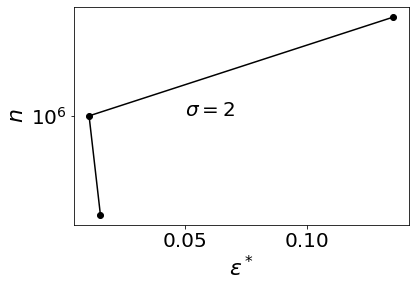

In [13]:
from matplotlib.ticker import ScalarFormatter

fig, ax = plt.subplots(1,1)
line = ax.plot(min_length[2:,1], min_length[2:,0], 'k-o', label = r'$\sigma=2$')
#ax.set_yticks(min_length[2:,1])

ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
#plt.ticklabel_format(style='sci', axis='y',scilimits= (0,0))
ax.set_yticks([ 10000, 100000, 1000000])
ax.set_yscale('log')
#plt.ticklabel_format(useOffset=False)
plt.minorticks_off()
ax.annotate(r'$\sigma=2$',(0.05,10**6))
ax.set_xlabel(r'$\epsilon^*$')
ax.set_ylabel(r'$n$')

#plt.majorticks_off()

#ax.legend()
fig.show()

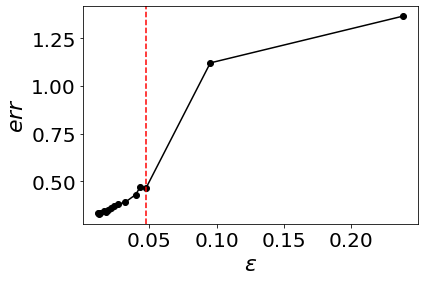

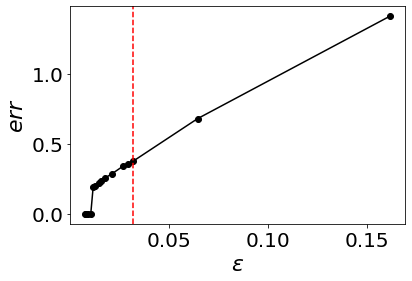

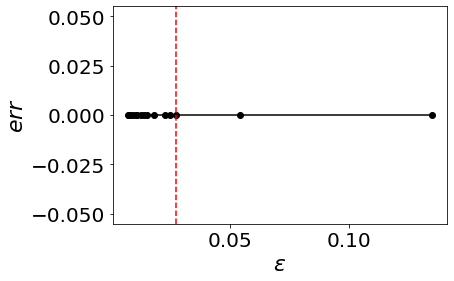

In [14]:
indexes = [200000, 1000000, 2000000]

for indx in indexes:
    fig, ax = plt.subplots(1,1)
    plt.plot( box_lengths.loc[indx],ERRORS_pd.loc[indx],'k-o')
   # ax.set_yscale('log')
    e_used = 1/int(indx**(1/4))
    ax.axvline(e_used, c = 'r', linestyle = '--')
    ax.set_xlabel(r'$\epsilon$')
    ax.set_ylabel(r'$err$')